# Clustering of Total Dataset 2 (10% Intervals)
In the following Notebook, we will be examining and contrasting participants based on their total net income or net loss over the course of the test measured at 10% intervals. That is to say that, for a participant with 100 turns, we will examine their *10th*, *20th*, *30th*, .., and *100th* round. Clustering participants based on these features will result in a **10-Dimensional space**. We will then perform *Principal Component Analysis* to understand which of these features are most important. Depending on the results of PCA, we will either perform dimensionality reduction or choose to continue with all 10 features.  

## Importing Libraries

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn import preprocessing
import matplotlib.cm as cm

## Importing Data

In [49]:
full_sets = []

full_wins_95=pd.read_csv("../data/cleaned/full_Wins_95.csv")
full_sets.append(full_wins_95)
full_wins_100=pd.read_csv("../data/cleaned/full_Wins_100.csv")
full_sets.append(full_wins_100)
full_wins_150=pd.read_csv("../data/cleaned/full_Wins_150.csv")
full_sets.append(full_wins_150)

full_losses_95=pd.read_csv("../data/cleaned/full_Losses_95.csv")
full_sets.append(full_losses_95)
full_losses_100=pd.read_csv("../data/cleaned/full_Losses_100.csv")
full_sets.append(full_losses_100)
full_losses_150=pd.read_csv("../data/cleaned/full_Losses_150.csv")
full_sets.append(full_losses_150)

## Initial Data Manipulation
From the datasets we previously created, we would like to calculate a participant's net gain (or loss) at each measured interval for each subject. The calculation is simply  the difference between **`full_win` & `full_loss`**.

In [ ]:
#Our Net Datasets
net_sets = []

net_rolling_95=full_wins_95.iloc[:,:-2] + full_losses_95.iloc[:,:-2].values
net_sets.append(net_rolling_95)

net_rolling_100=(full_wins_100.iloc[:,:-2] + full_losses_100.iloc[:,:-2].values)
net_rolling

In [63]:
#Our Net Datasets
net_sets = []

net_rolling_95=full_wins_95.iloc[:,:-2] + full_losses_95.iloc[:,:-2].values
net_sets.append(net_rolling_95)

net_rolling_100=(full_wins_100.iloc[:,:-2] + full_losses_100.iloc[:,:-2].values)
net_rolling_100=pd.concat([net_rolling_100, full_wins_100.iloc[:,-2:]], axis=1)
net_sets.append(net_rolling_100)

net_rolling_150=full_wins_150 + full_losses_150.values
net_sets.append(net_rolling_150)

In [4]:
#Normalising table columns
for s in net_sets:
    new_columns=["10%", "20%", "30%", "40%", "50%","60%", "70%", "80%", "90%", "100%"]
    s.set_axis(new_columns, axis=1, inplace=True)

In [5]:
#Let us now combine our datasets
net_set = pd.concat(net_sets, axis=0)

# K-Means Clustering
As is stands, our dataset consists of 10 features. We know that the K-Means algorithm suffers from the 'curse of dimensionality'. This means that as the dimensions increase, the amount of available space increases exponentially. Eventually, we reach a point where our space is so sparsely populated that K-Means resorts to a 1:1 relationship between number of clusters and number of datapoints.

To avoid this paradigm, we will perform **Principal Component Analysis** (PCA). PCA is used for dimensionality reduction in datasets with many features. On their own, these datasets are difficult to interpret and cannot be plotted on a 2D or 3D plane. PCA aims to increase the interpretability of these datasets. It creates new variables (__*principal components*__) that maximize variance. It then solves these variables for their eigenvalues and eigenvectors {cite}`Jolliffe2016`.

## Principal Component Analysis
In order for PCA to work, the data must be standardized. That is to say, all of our features must have a **mean of 0** and a **Standard Deviation of 1**. We will use the `preprocessing` package from `sklearnn` in order to achieve this. Following on from this, we will create as many principal components as there are feature vectors. We will then rank the importance of these principal components by calculating their **eigenvalues**. The comparison of the eigenvalues will allow us to visualise the importance of each. That is, how much variance in the true dataset they are able to account for. We will see this on a **Scree Plot**.

### Standardization

In [6]:
#Instantiate our scaler
min_max_scaler = preprocessing.MinMaxScaler()

#Normalize our dataset
norm_net_set=pd.DataFrame(min_max_scaler.fit_transform(net_set), columns=net_set.columns)

### Finding Principal Components

In [23]:
#Instantiating our PCA Function
pca = PCA(n_components=10, svd_solver = 'auto')

#Finding the 10 Principal Components of our Datasets
pc_norm_net=pca.fit_transform(norm_net_set)


#Creating datasets of the principal components for visualization
pca_df_norm_net_set = pd.DataFrame(data = pc_norm_net, columns = ['PC 1', 'PC 2', 'PC 3',
                                                       'PC 4', 'PC 5', 'PC 6',
                                                      'PC 7', 'PC 8', 'PC 9', 'PC 10'])

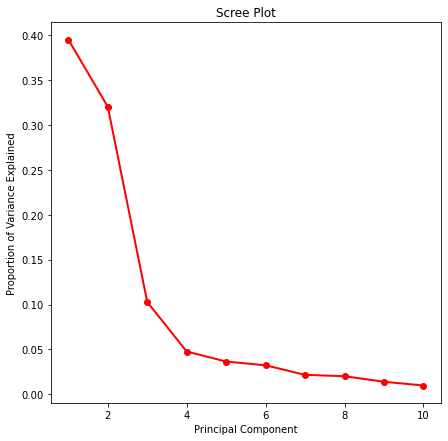

In [24]:
#Creating the Scree Plot
plt.figure(figsize=(7,7))

PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [9]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)  
    
out_sum = np.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.39471861 0.32002395 0.10276651 0.04771292 0.03652619 0.0323709
 0.02174367 0.02018602 0.0140641  0.00988714]
Cumulative Prop. Variance Explained:  [0.39471861 0.71474256 0.81750906 0.86522198 0.90174817 0.93411907
 0.95586274 0.97604875 0.99011286 1.        ]


### Scree Plot Analysis
From the above plot we can see that **71.4%** of the variance in our total dataset is explained by the first and second Principal Components. With this evidence, we can conclude that the first and second Principal Components will suffice for representing the majority (over 70%) of the variance in our data. 

## Deciding Value of K
We must now decide on a suitable amount of clusters for our algorithm. Two largely used methods for discovering the value of K are: $(a)$ *The Elbow Method*, and $(b)$ *The Silhouette Method*.

### $(a)$ The Elbow Method
Inelegantly named the **Elbow Method**, it is the oldest method for determining the correct value of K. It is a visual method that focuses on displaying the error cost associated with varying amounts of clusters. The error is known as **the Sum of the Squared Error** (SSE). Visually, the total amount of error will fall at each increment of total number of clusters before reaching a point where it plateaus. This point is known as the elbow point. The loss in error beyond this point is not considerable enough to warrant the use of extra clusters {cite}`Kodinariya2013`. The algorithm for calculating the loss function is as follows:
* where $k$ is the number of clusters
* $n$ is the number of points in cluster $j$
* $c$ is the centroid for cluster $j$
$$SSE = \sum_{j=1}^k\sum_{i=1}^n{(y^{\mathrm{(j)}}_{i} - c_{j})^2}$$

**Note**: An error I made in the previous notebook was not 'seeding' my k-means algorithm. Because of this, on future runs of the same notebook, the algorithm will produce a different output. In the below example, we will use a seed (`random_state`) of 10.

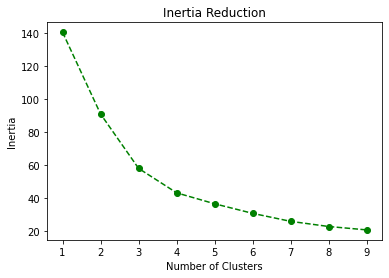

In [28]:
#Let X equal our points. We use only the first and second Principal Components
X = pca_df_norm_net_set.iloc[:,:2]

#List of inertias
inertias = []

#Finding and appending Inertia to list
for i in range(1, 10):
    kmeans = KMeans(n_clusters=i, random_state=10).fit(X)
    inertias.append(kmeans.inertia_)

#Create Inertia Line Plot
plt.plot(range(1,10), inertias, "go--")
plt.title('Inertia Reduction')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

From the above graph, it is difficult to understand whether or not 3 or 4 clusters would be considered the better option. Let's do a cross examination using our next method for determining k.

### $(b)$ The Silhouette Method
The Silhouette method is also used to determine the best value for K. This method measures the similarity of each point to its own cluster versus every other cluster. The method provides a **succinct graphical representation** describing how well each data point $(i)$ is described.
The steps to find the Silhouette Score of data point $i$ are as follows:
* Compute $a_{i}$: The average distance of that point with all other points in the same cluster.
* Compute $b_{i}$: The average distance of that point with all the points in the closest cluster to its cluster.
* Compute $S_{i}$ — silhouette coefficient or i’th point using below mentioned formula.

The formula is as follows: $$S_{i} = \frac{b_{i} - a_{i}}{\max{(b_{i}, a_{i})}}$$

Once you obtain all of the **Silhouette Coefficients** (all $S_{i}$), you find the average to achieve the silhouette score.

For n_clusters = 2 The average silhouette_score is : 0.3540661377361447
For n_clusters = 3 The average silhouette_score is : 0.3899300210703239
For n_clusters = 4 The average silhouette_score is : 0.3901970654091925
For n_clusters = 5 The average silhouette_score is : 0.34447383123098063


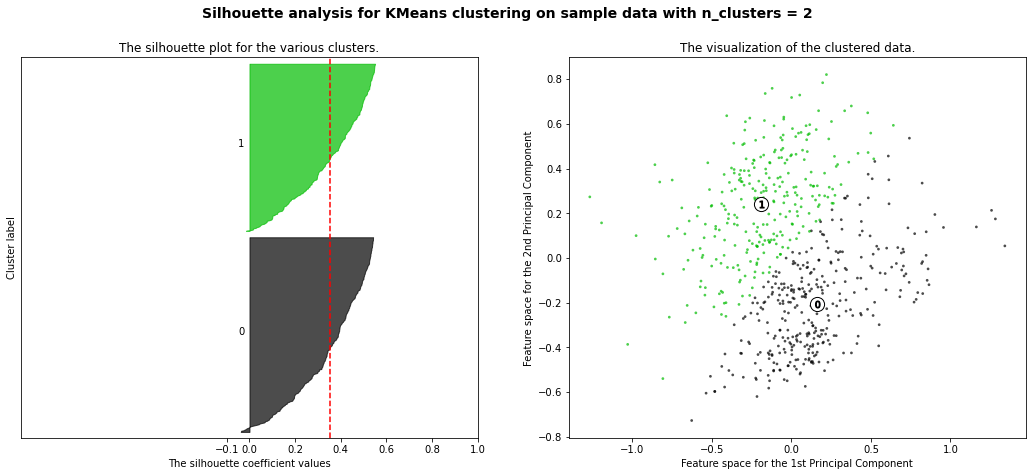

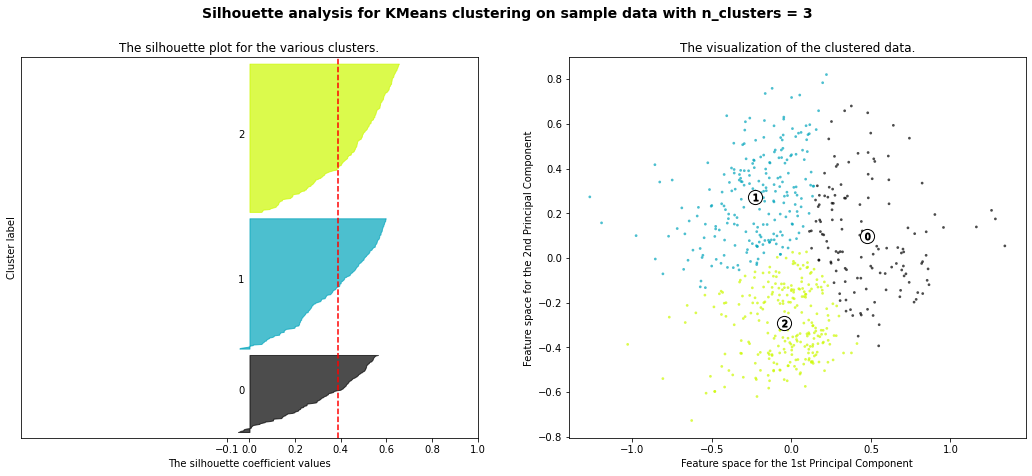

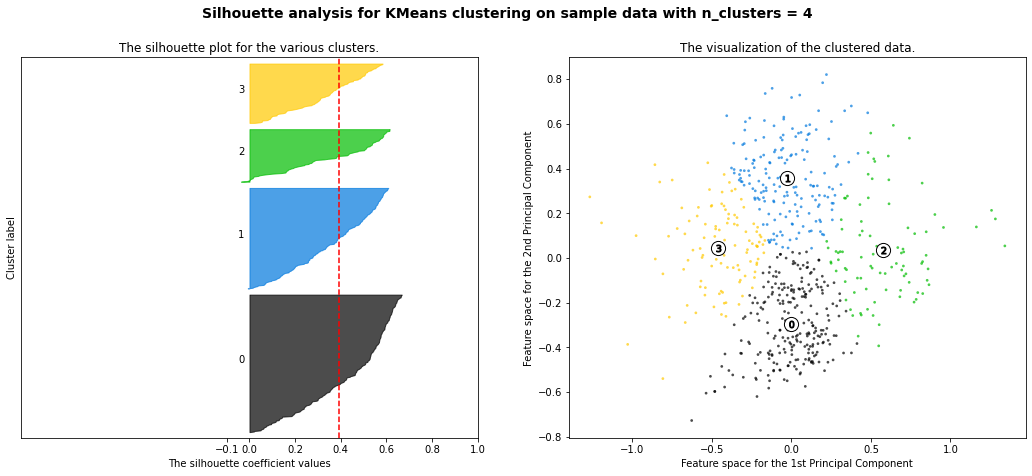

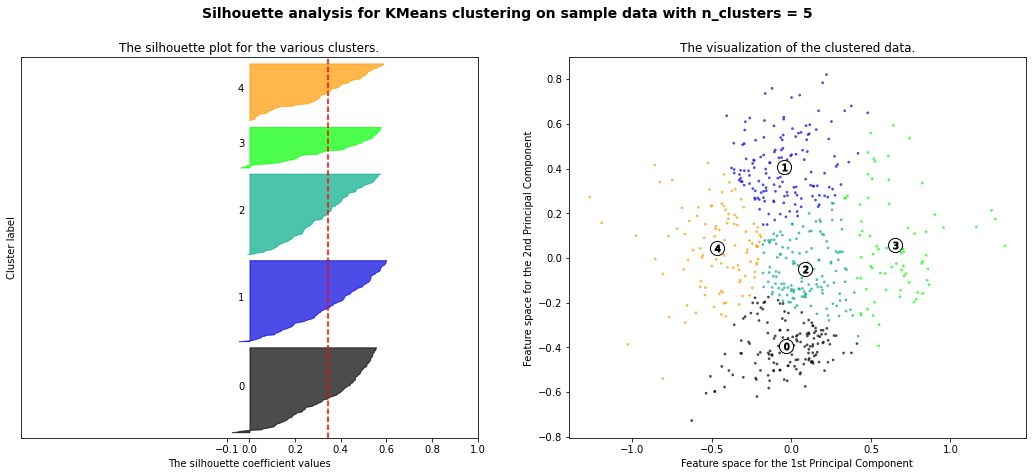

In [44]:
#Defining the range of clusters
range_n_clusters = [2, 3, 4, 5]

#Letting PC1 & PC2 = X
X = pca_df_norm_net_set.iloc[:,0:2]

#Defining subplots
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    #Setting x-axis lim
    ax1.set_xlim([-1, 1])

    #Creating spacing on y-lim
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #initialising clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st Principal Component")
    ax2.set_ylabel("Feature space for the 2nd Principal Component")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The silhouette scores displayed above finalise our decision that 4 clusters is the most suitable amount. Although, it should be noted that there is very slight increase in score between 3 and 4 clusters. This is likely due to the data distribution. From the visualizations on the right, it is clear that this data is evenly distributed. Visually, it is difficult to seperate clusters by eye. This is to be expected as this dataset is supposed to represent "*a super control set*". The inclusion of extra data (possibly of participants with cognitive disorders) would have allowed for more suitable clustering. 

## Clustering
We will now reproduce our K-Means clustering algorithm with $K = 4$ . Again, for reproducability, we will seed our algorithm with the value 10. In order to analyse the clusters, we will colour each data point depending on the study it is part of. This will allow us to understand if there is a relation between clusters chosen vs origin of the data. We will use the `seaborn.sns` scatterplot package for this visualization. 

In [139]:
#Let's append our studies to the data

studies = pd.concat([full_wins_95.iloc[:,-1:],full_wins_100.iloc[:,-1:],full_wins_150.iloc[:,-1:]]).reset_index(drop=True)

pc1_pc2_with_studies = pd.concat([pca_df_norm_net_set.iloc[:,0:2], studies], axis=1)

The total inertia (SSE) is: 43.04


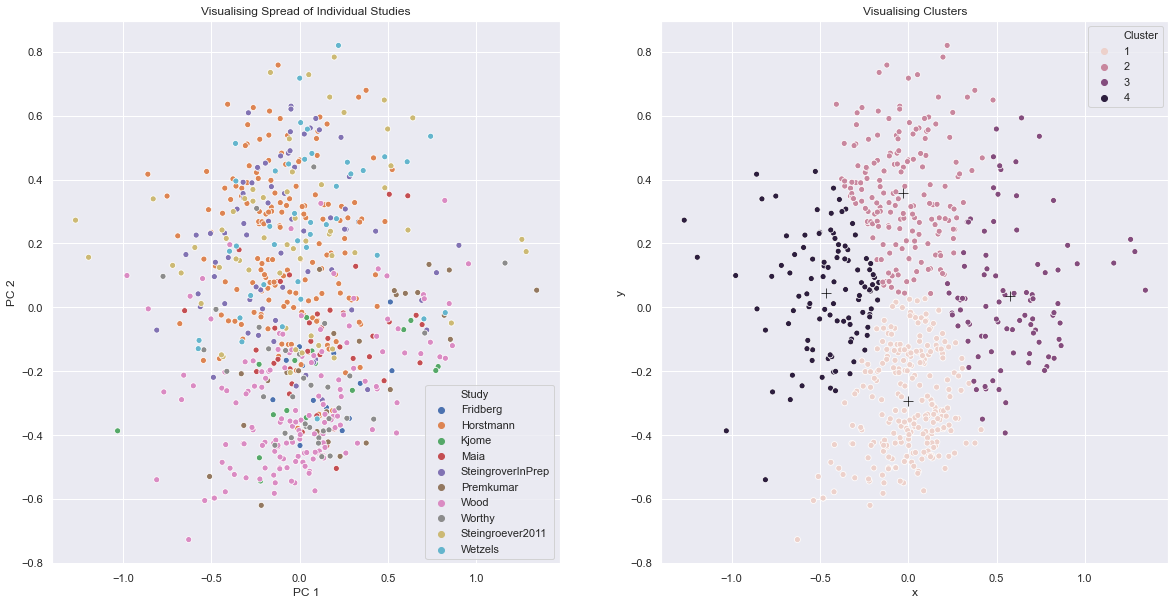

In [197]:
import seaborn as sns
sns.set(style='darkgrid')

kmeans = KMeans(n_clusters=4, random_state=10).fit(pc1_pc2_with_studies.iloc[:,:2])
pc1_pc2_with_studies["Cluster"] = kmeans.labels_ + 1
fig, axs = plt.subplots(1,2,figsize=(20,10))

#Printing inertia
print(f'The total inertia (SSE) is: {kmeans.inertia_:.2f}')

#Setting titles
axs[0].set_title("Visualising Spread of Individual Studies")
axs[1].set_title("Visualising Clusters")

#Plotting points
sns.scatterplot(x='PC 1', y='PC 2', data=pc1_pc2_with_studies, hue='Study', ax=axs[0])
sns.scatterplot(x='PC 1', y='PC 2', data=pc1_pc2_with_studies, hue='Cluster', ax=axs[1])

#Setting centroids for cluster graph
sns.scatterplot(x='x', y='y', data=centers, ax=axs[1], marker="+", s=100, color=".05", alpha=1)
plt.show()

### Cluster Analysis
It is interesting to see that visually, there seems to be more data points from particular studies included in certain clusters. For example, viewing cluster 1, we can see that the majority of the datapoints consist of subjects from the {cite}`Wood2005` study. Again, it would have been ideal to be able to compare these graphs with the inclusion of participants outside of the control group. Unfortunately, due to time constraints, I will not be performing this research as part of this assignment.

However, something we can do instead is measure the proportions of each cluster made up of the studies. Perhaps we will prove that cluster 1 is infact majorly consisting of participants from the {cite}`Wood2005` study. In our next notebook we will before a **Federated Learning** approach on the same data. We can conclude by comparing the proprtions of the clusters. As the data is a control group with even distribution, possibly a federated approach will result in the data points being more evenly spread amongst clusters. We will also compare the SSE of the two methods.

To do this, we must convert our Study column values into numerical values. This is called **Encoding**.

In [142]:
#Instantiate the Encoder
le = preprocessing.LabelEncoder()

#Fit it to our Study 
le.fit(pc1_pc2_with_studies.Study.unique())

#Create a Count column for summation
pc1_pc2_with_studies["Count"]=1

In [193]:
pc1_pc2_with_studies[["Cluster", "Study", "Count"]].groupby(["Study", "Cluster"]).sum()

Count
Study             Cluster       
Fridberg          1           12
                  3            3
Horstmann         1           27
                  2           86
                  3           14
                  4           35
Kjome             1           14
                  3            4
                  4            1
Maia              1           24
                  2            2
                  3           11
                  4            3
Premkumar         1           12
                  2            1
                  3           11
                  4            1
Steingroever2011  1            8
                  2           24
                  3            9
                  4           16
SteingroverInPrep 1            7
                  2           35
                  3            7
                  4           21
Wetzels           1            3
                  2           24
                  3            6
                  4            8
Wood              1          110
                  2            3
                  3           25
                  4           15
Worthy            1           25
                  2            2
                  3            3
                  4            5

We can see from the above table that Cluster 1 does infact contain a large amount of subjects from the {cite}`Wood2005`. In a similar fashion, cluster 2 holds a majority of the {cite}`hortsmanm2012` data points. It will be interesting to see if the Federated approach yields different results.